In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import torch
import torchvision
import torchvision.datasets as datasets
import sys
import numpy as np
import torch.utils.data as utils
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import pickle as pkl

from os.path import join as oj
import matplotlib.pyplot as plt
%matplotlib inline
import os
import seaborn as sns
sns.set()

In [5]:
import torch
import torchvision
import torchvision.datasets as datasets
import sys
import matplotlib.pyplot as plt
import numpy as np
import torch.utils.data as utils
from sklearn.metrics import auc,average_precision_score, roc_curve,roc_auc_score

In [6]:
save_path = "../results_for_export"

In [7]:
from torch import nn

In [8]:
device = torch.device("cuda")

In [9]:
import torchvision.models as models

model = models.vgg16(pretrained=True).to(device)
model.classifier[-1] = nn.Linear(4096, 2)
model.load_state_dict(torch.load('cancer_prim.pt'))
model = model.to(device)

In [18]:
mean = np.asarray([0.485, 0.456, 0.406])
std = np.asarray([0.229, 0.224, 0.225])

In [10]:
data_root  = "../../../datasets/ISIC"
data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
img_dataset = datasets.ImageFolder(data_root,transform=data_transform)
num_total = len(img_dataset)
num_train = int(0.8 * num_total)
num_val = int(0.1 * num_total)
num_test = num_total - num_train - num_val
torch.manual_seed(0);
train_dataset, test_dataset, val_dataset= torch.utils.data.random_split(img_dataset, [num_train, num_test, num_val])

In [11]:
datasets = {'train' : train_dataset, 'test':test_dataset, 'val': val_dataset}
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=16,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test','val']}

In [12]:

not_cancer_ratio = np.asarray(train_dataset.dataset.targets).mean() 
cancer_ratio = 1- not_cancer_ratio
cancer_weight = 1/cancer_ratio
not_cancer_weight = 1/ not_cancer_ratio
weights = np.asarray([cancer_weight, not_cancer_weight])
weights /= weights.sum()
weights = torch.tensor(weights).to(device)

In [25]:

import csv
import numpy as np
from skimage.transform import probabilistic_hough_line
from skimage.feature import canny
from shutil import copyfile
from os.path import join as oj
from PIL import Image
from tqdm import tqdm
from skimage.color import rgb2gray
def has_line(img):
    bw_img = rgb2gray(img)
    lines = probabilistic_hough_line(canny(bw_img, sigma=2), threshold=40, line_length=200,
                                 line_gap=10)
    lines = [line for line in lines if line[0][0] != line[1][0] and line[0][1] != line[1][1]  ]
    
    return len(lines) >0
    
    

In [24]:
(inputs[0].cpu().numpy() *std[:, None, None]+mean[:, None, None]).min()

2.7418136649970393e-09

In [14]:
model.eval()
y = []
y_hat = []
has_line = []
softmax= torch.nn.Softmax()
with torch.no_grad() :
    for inputs, labels in dataloaders['val']:
        y_hat.append((1-labels).cpu().numpy())
        y.append(torch.nn.Softmax()( model(inputs.cuda()))[:,0].detach().cpu().numpy())
y_hat = np.concatenate( y_hat, axis=0 )
y = np.concatenate( y, axis=0 )

/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site

KeyboardInterrupt: 

In [17]:
auc_score = roc_auc_score(y_hat, y)

In [18]:
num_fp = (y > 0.5)[np.where(y_hat == 0)].sum()
num_tp = (y > 0.5)[np.where(y_hat == 1)].sum()

num_fn = (y < 0.5)[np.where(y_hat == 1)].sum()
num_tn = (y < 0.5)[np.where(y_hat == 0)].sum()


In [19]:
x_vals= np.linspace(0, 1, num = 1000)

In [20]:
specificity  = np.empty((1000))
sensitivity  = np.empty((1000))

In [21]:
for i in range(1000):
    specificity[i] = (y[np.where(y_hat == 0)] <x_vals[i]).mean()
    sensitivity[i] = (y > x_vals[i])[np.where(y_hat == 1)].mean()


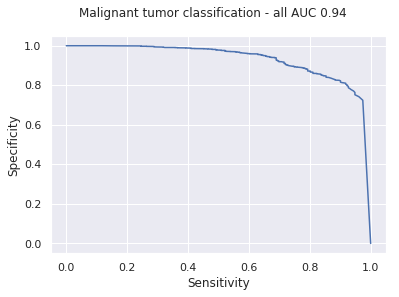

In [24]:
fig, ax = plt.subplots()
ax.plot(sensitivity, specificity)
ax.set_ylabel("Specificity");
ax.set_xlabel("Sensitivity");
fig.suptitle("Malignant tumor classification - all AUC {:2.2f}".format(auc_score))
fig.savefig(oj(save_path, "Vanilla_skincancer"))
